##0. Imports

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
!pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, fbeta_score, make_scorer, classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from feature_engine.creation import CyclicalFeatures
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import optuna

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import tqdm
import copy
from torchvision.io import read_image
import os
from torchmetrics import Accuracy
from torchsummary import summary

In [ ]:
SEED = 22
sns.set(rc={"figure.figsize":(12, 8)})


I'll try to fix seed to get simmilar results every time.

In [ ]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(12)

Next 2 chapters were copied from previous HW.

## 1. Initial data preparation and EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/hw3/AirQualityUCI.csv', sep=';')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


### Initaial data preparetion - dealing with types and standart nan values.

There are weird columns n the end, those are probaby false so i'll investigate and probably delete them.

In [ ]:
print(df.shape)
df.value_counts(['Unnamed: 15', 'Unnamed: 16'])

(9471, 17)


Series([], dtype: int64)

In [ ]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [ ]:
df.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

The fact that CO(GT), C6H6(GT), T, RH and AH are considered objects is due to the fact that they use ',' instead of '.'.

In [ ]:
df[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']]

,CO(GT),C6H6(GT),T,RH,AH
0,"2,6","11,9","13,6","48,9","0,7578"
1,2,"9,4","13,3","47,7","0,7255"
2,"2,2","9,0","11,9","54,0","0,7502"
3,"2,2","9,2","11,0","60,0","0,7867"
4,"1,6","6,5","11,2","59,6","0,7888"
...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN


In [ ]:
df[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']] = df[['CO(GT)','C6H6(GT)', 'T', 'RH', 'AH']].apply(lambda i: i.apply(lambda j: float(str(j).replace(',', '.'))))


In [ ]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In additional info about dataset is written that nan values are marked -200  and from above table i see that no negative values are meaningfull, so i can comvert them to nan.

In [ ]:
print(df[df == -200].count())
print(df[df == '-200'].count())
df = df.replace(-200, np.nan)

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [ ]:
print(df.isnull().sum())

Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64


Now let's convert date and time to datetime type.
format:
0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)



In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df['Date']

0      2004-03-10
1      2004-03-10
2      2004-03-10
3      2004-03-10
4      2004-03-10
          ...    
9466          NaT
9467          NaT
9468          NaT
9469          NaT
9470          NaT
Name: Date, Length: 9471, dtype: datetime64[ns]

In [ ]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Different columns have very different scales so i'll definetely use scaling.

In [ ]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

### EDA

First of all I would like to have a look at the columns individually.

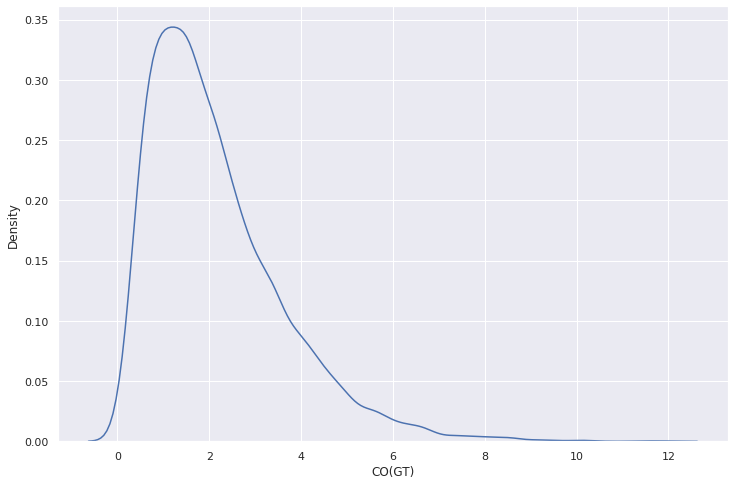

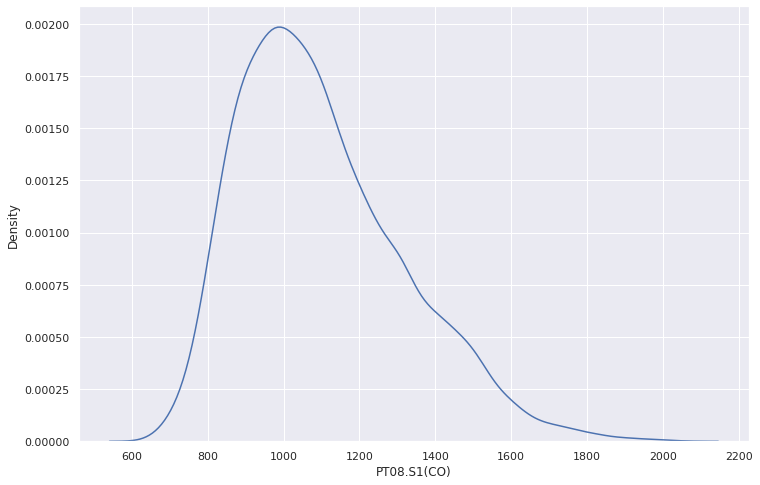

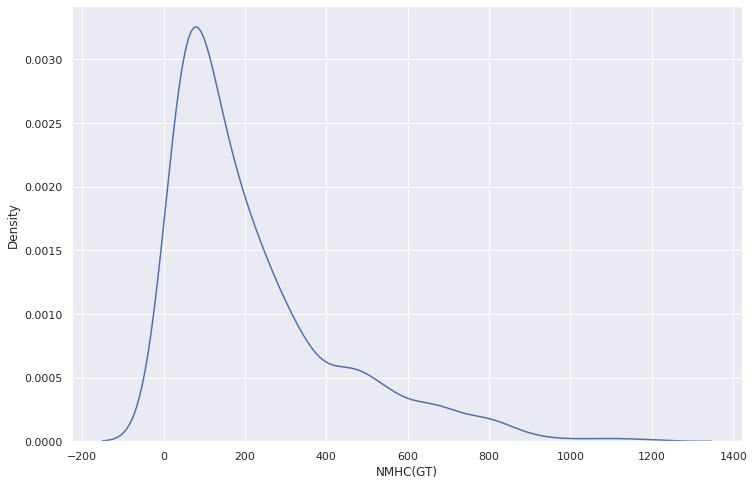

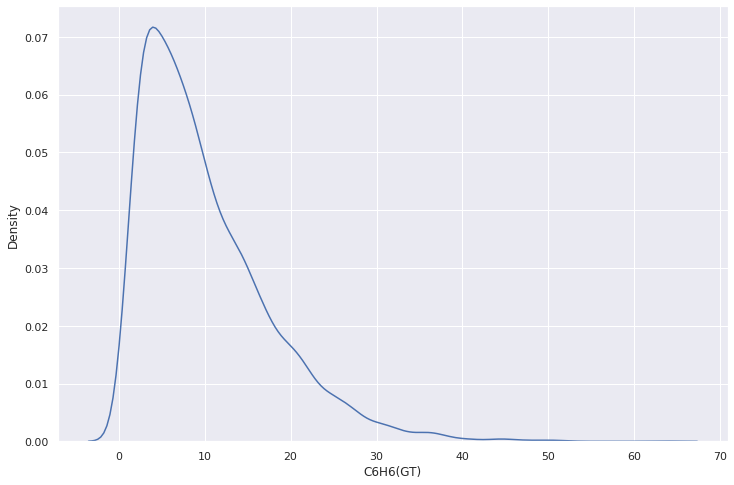

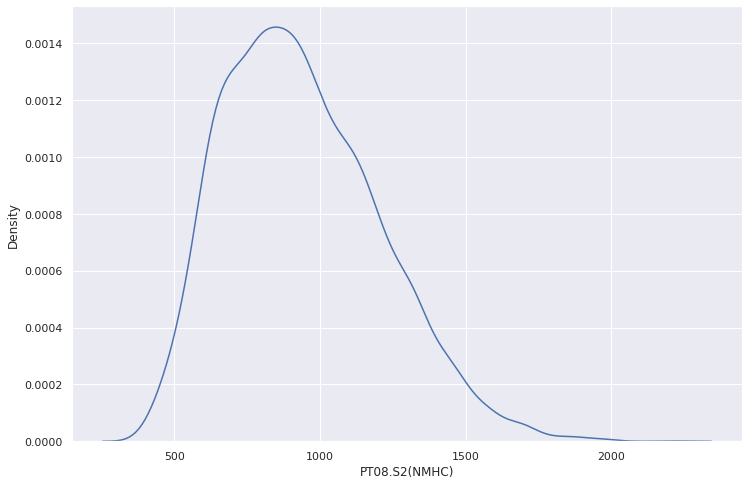

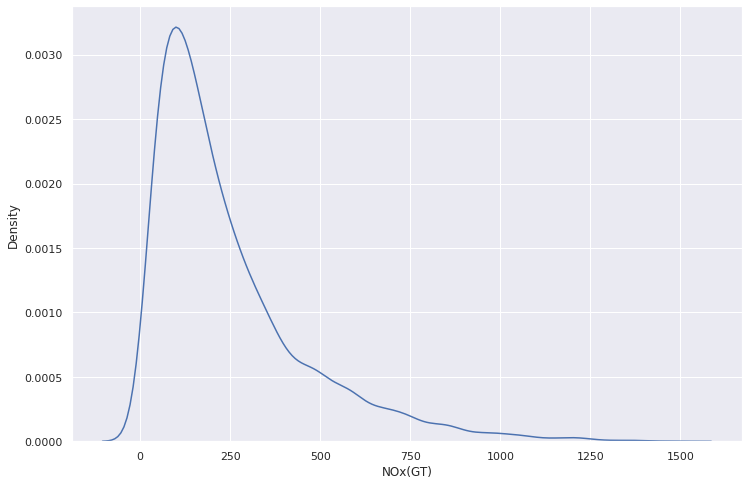

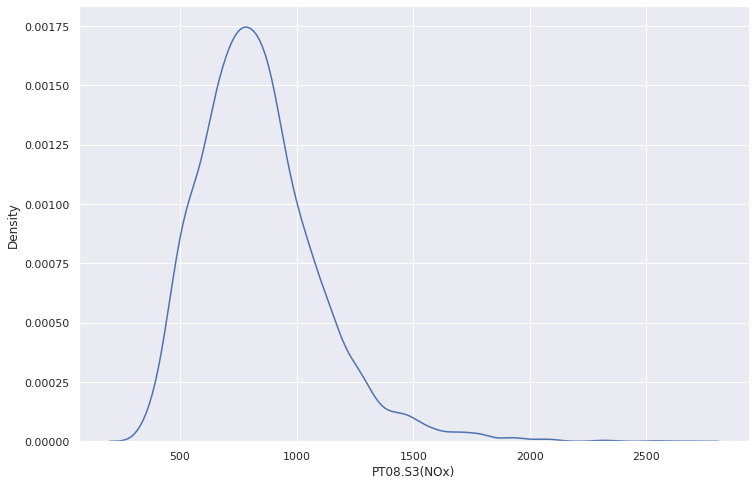

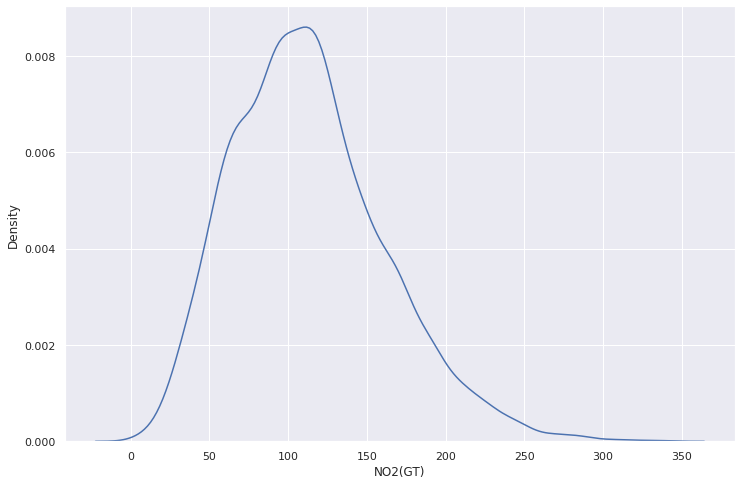

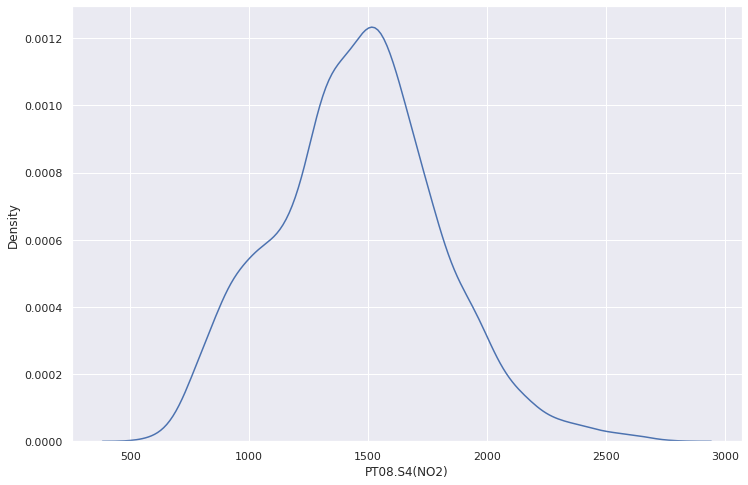

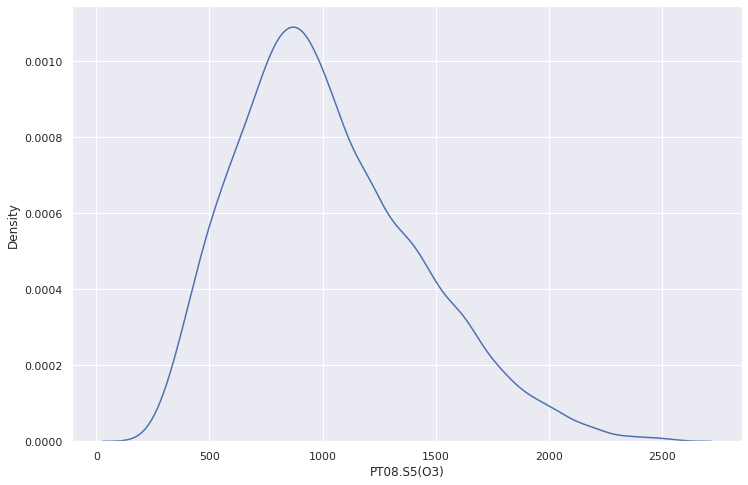

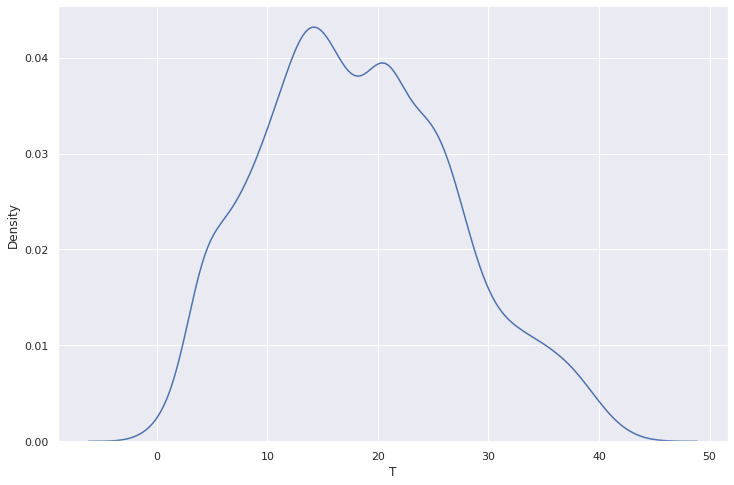

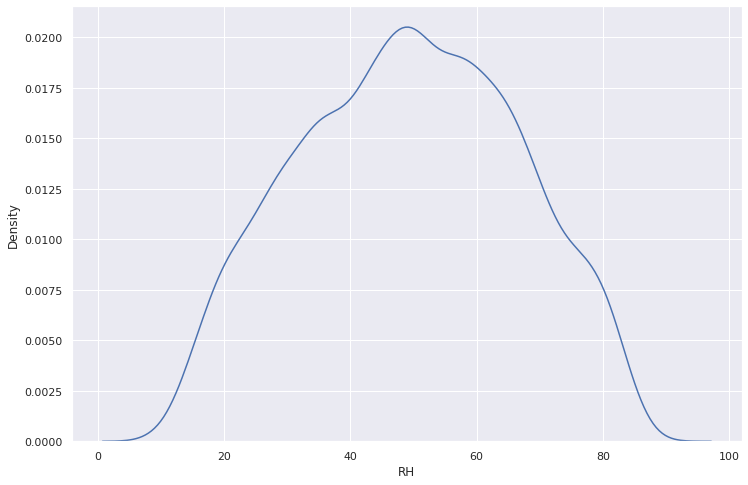

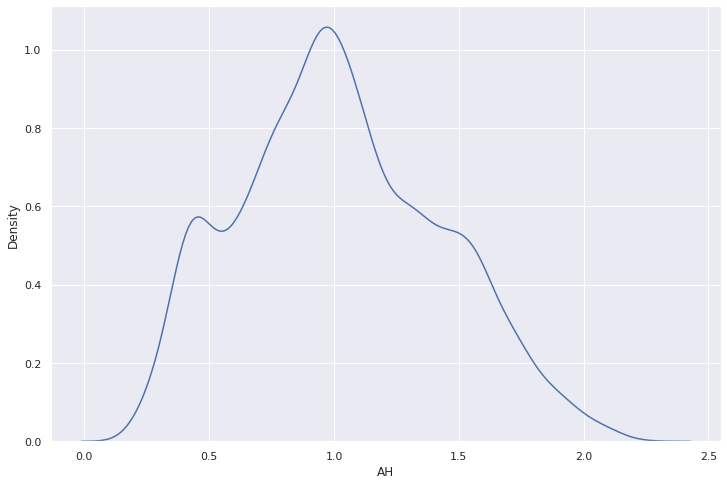

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
for col in df.columns:
  if df[col].dtype == 'float64':
    sns.kdeplot(data=df[col])
    plt.show();
    #plt.xticks(rotation = 90)


All the numeric variables seem to be normally-like distributed(perhaps there is sense to perform log transformation)

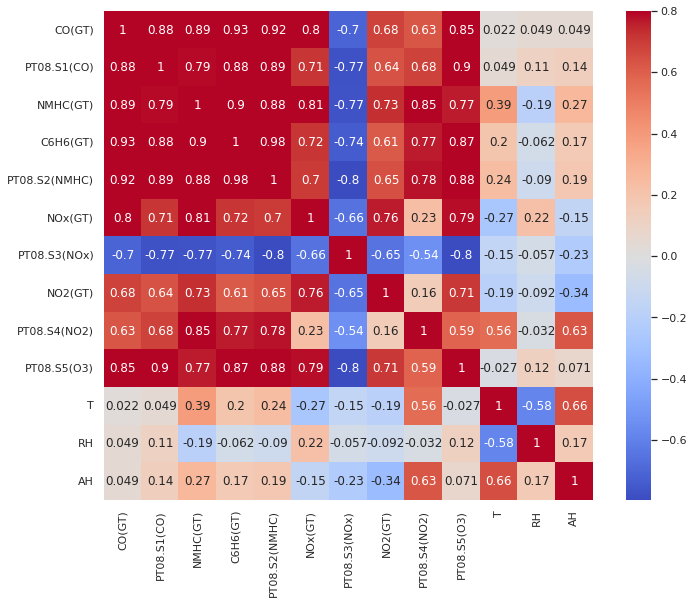

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="coolwarm", vmax=.8, square=True, annot=True);

In [ ]:

corrmat = corrmat.abs()
s = corrmat.unstack()
sorted = s.sort_values(kind="quicksort", ascending=False)
highest_cor = sorted[13:25]
highest_cor

PT08.S2(NMHC)  C6H6(GT)         0.981950
C6H6(GT)       PT08.S2(NMHC)    0.981950
               CO(GT)           0.931078
CO(GT)         C6H6(GT)         0.931078
PT08.S2(NMHC)  CO(GT)           0.915514
CO(GT)         PT08.S2(NMHC)    0.915514
C6H6(GT)       NMHC(GT)         0.902559
NMHC(GT)       C6H6(GT)         0.902559
PT08.S1(CO)    PT08.S5(O3)      0.899324
PT08.S5(O3)    PT08.S1(CO)      0.899324
PT08.S1(CO)    PT08.S2(NMHC)    0.892964
PT08.S2(NMHC)  PT08.S1(CO)      0.892964
dtype: float64

From corr map i see that target value(C6H6(GT) greately correlates with many columns but those columns greatlely correlate with each other so i might drop some of them as redundant. PT08.S2(NMHC), CO(GT), NMHC(GT), PT08.S1(CO), PT08.S5(O3) are all highly correleted.

In [ ]:
print(df.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
numerical_cols.remove('C6H6(GT)')

In [ ]:
#sns.pairplot(df)

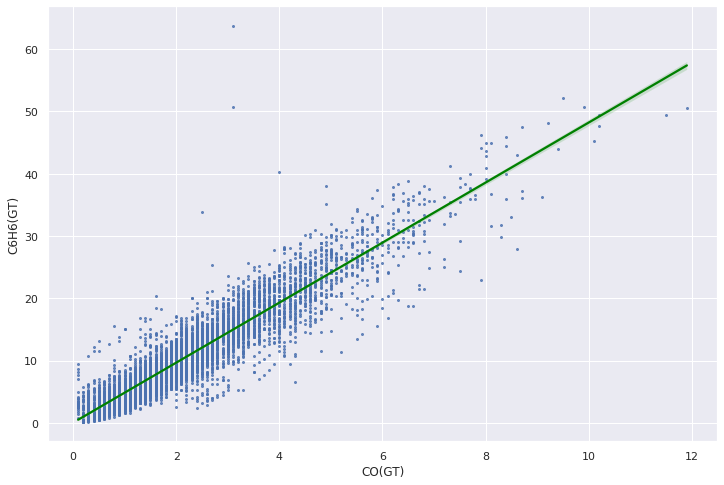

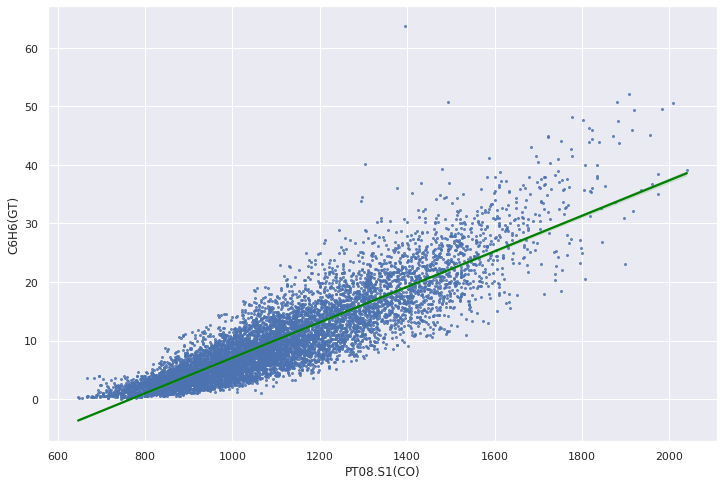

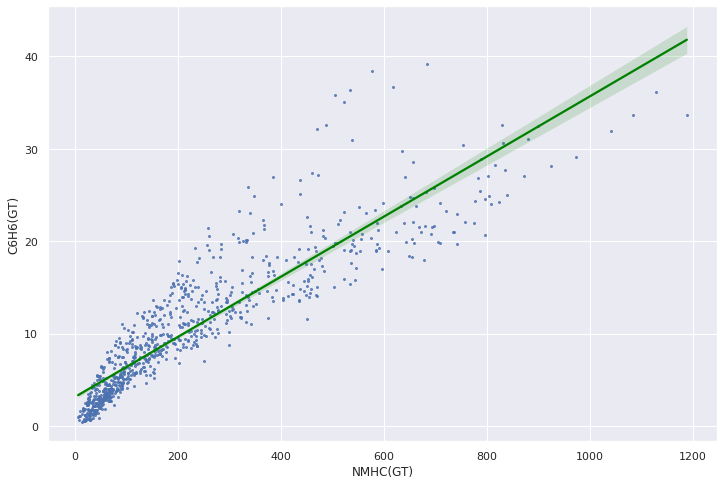

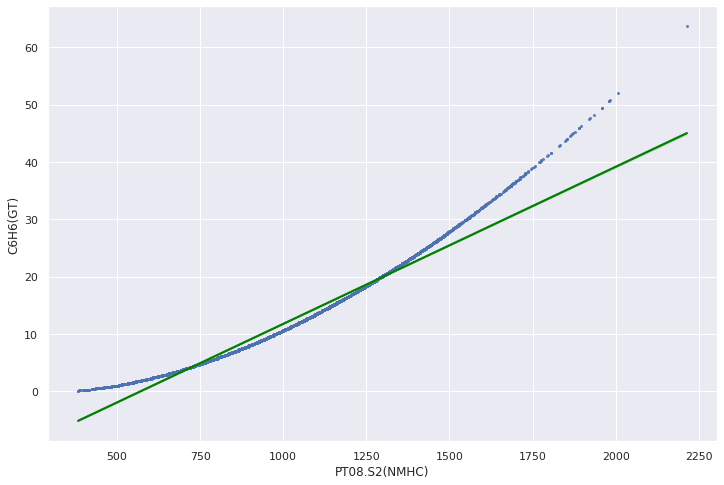

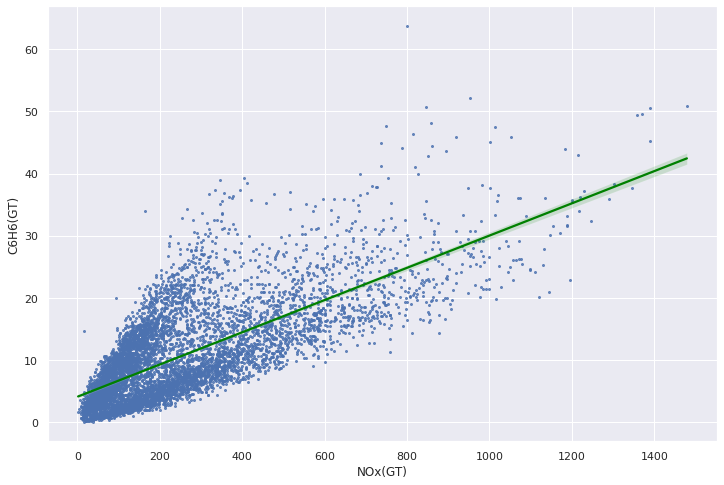

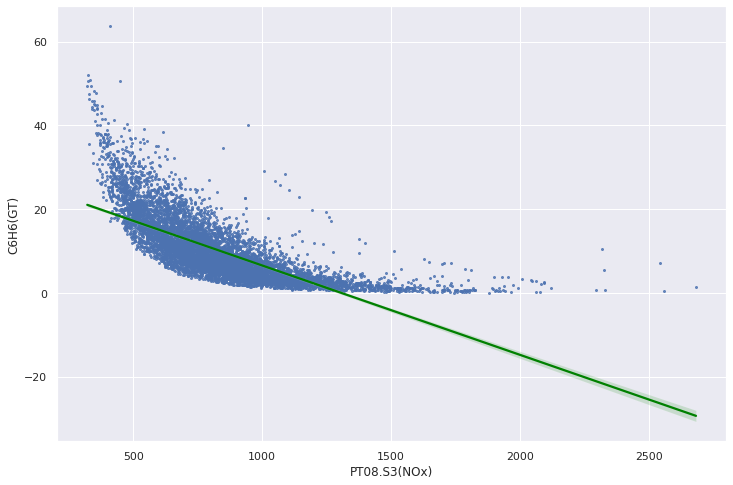

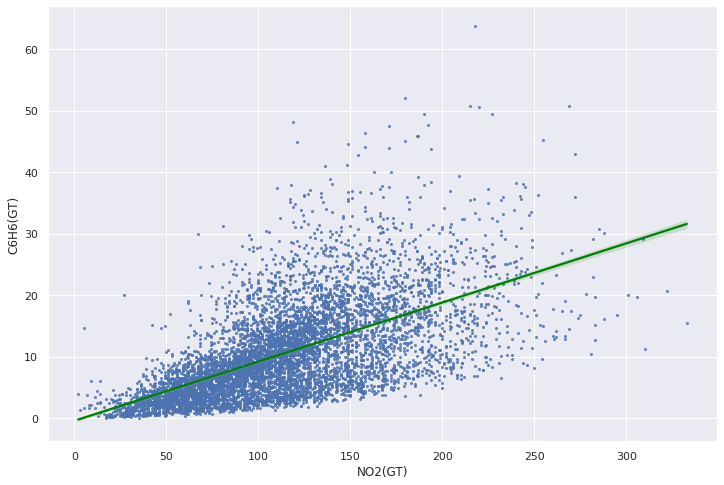

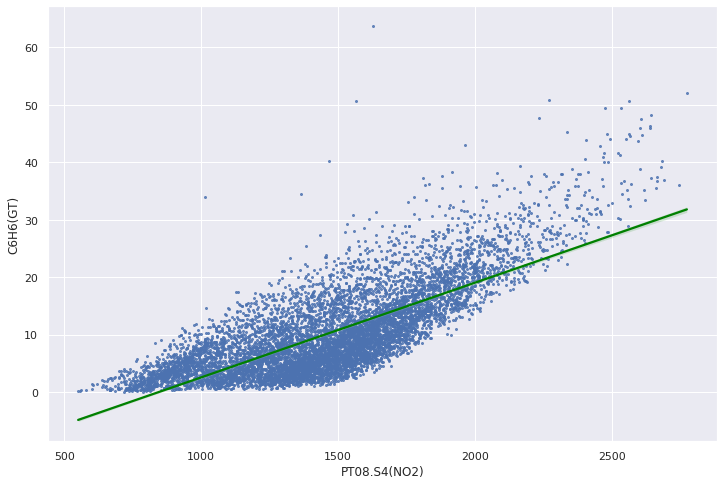

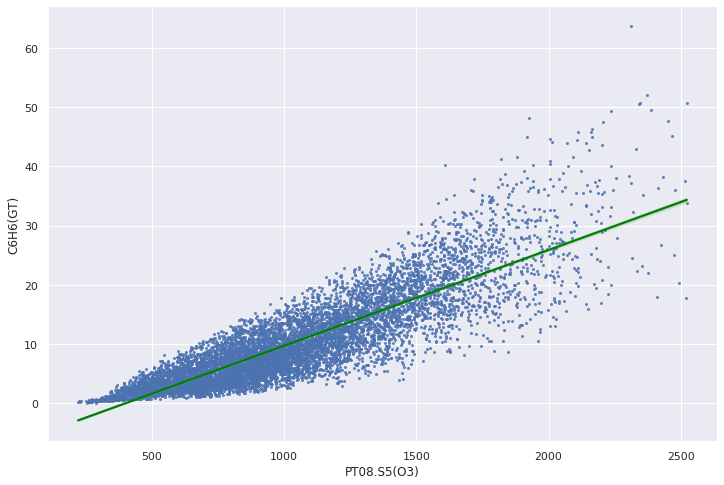

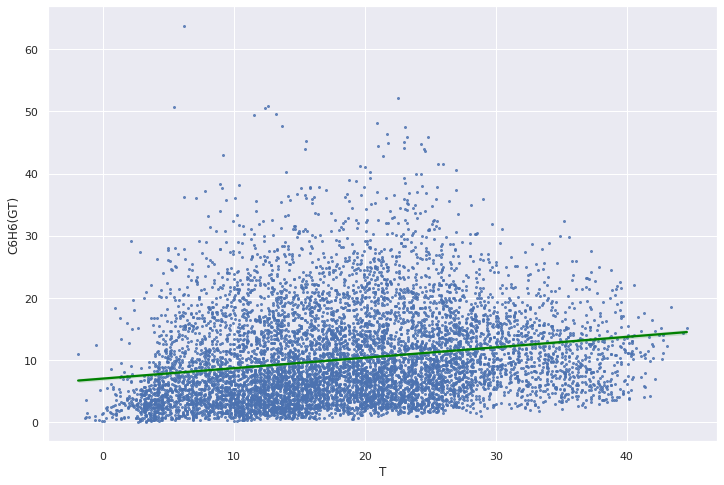

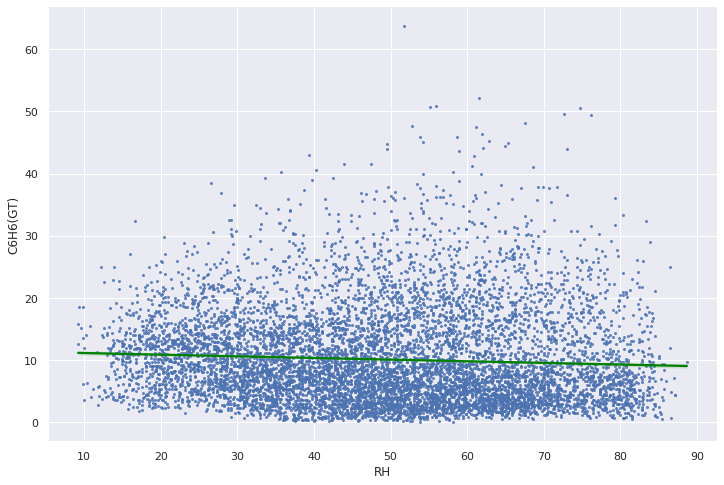

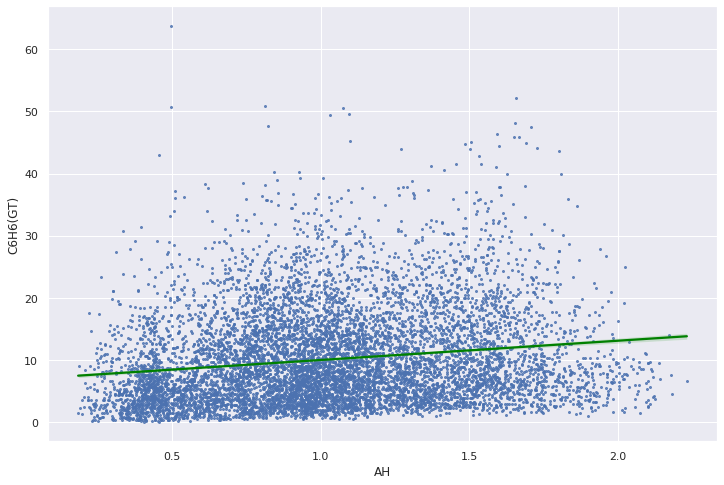

In [ ]:
def reg(data, cols):
  for col in cols:
    if data[col].dtype == 'float64':
      sns.set(rc={"figure.figsize":(12, 8)})
      sns.regplot(x=data[col], y=df['C6H6(GT)'], scatter_kws={"s": 4}, line_kws={'color': 'green'})
      plt.show();

reg(df, numerical_cols)

From regplots i see quite clear connection between some properties and target. Especially with 'PT08.S2' which seem be nearly idealy correlated to target value. From addiotional info i see that this feature is a sensor of NMHC but it looks like a data leakage. I'll try to predict C6H6 without this feature for situations when we don't have this particular sensor.

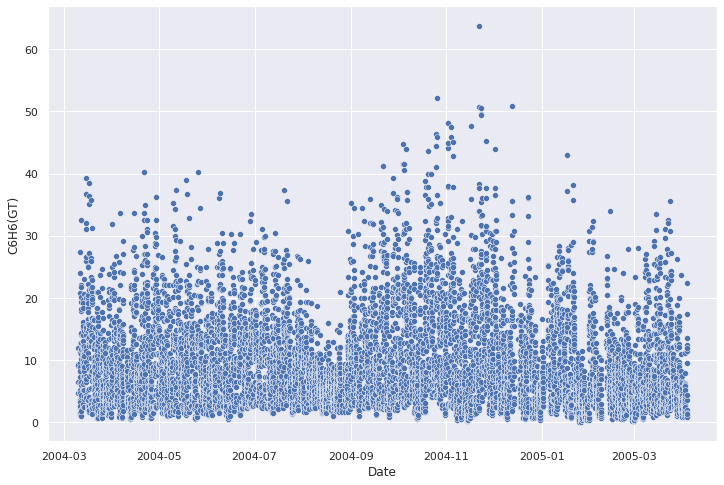

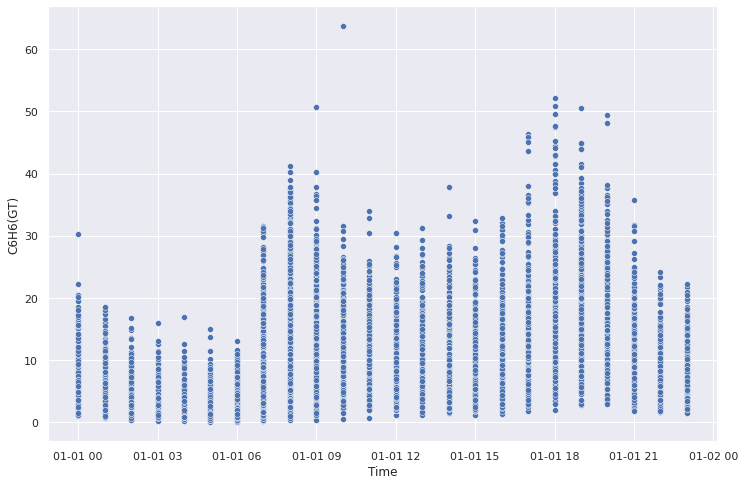

In [ ]:
sns.scatterplot(x=df['Date'], y=df['C6H6(GT)'])
plt.show()
ax = sns.scatterplot(x=df['Time'], y=df['C6H6(GT)'], )
#ax.set_xticks(df['Time'].apply(lambda x: x.time()))
plt.show()

From above pots i see that target value don't seem to be very connected to time and adequate time series analisys requaries additional knowledge so i will use it only to do time series split.

To sum up, I am going to drop this and all the true (not collected by sensors) variables : 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)' as if we have direct measurements of target value or even true values of substencies we don't need a model. I'll drop them later on in data preparation part.

##2. Data preparation


### Dropping data and outliers

Drop of some columns as i've mentioned earlier.

In [ ]:
df = df.drop(['CO(GT)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)'], axis=1)

In [ ]:
df.head()

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,1900-01-01 18:00:00,1360.0,11.9,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,1900-01-01 19:00:00,1292.0,9.4,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,1900-01-01 20:00:00,1402.0,9.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,1900-01-01 21:00:00,1376.0,9.2,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,1900-01-01 22:00:00,1272.0,6.5,1205.0,1490.0,1110.0,11.2,59.6,0.7888


### Missing data

In [ ]:
print(df.isnull().sum())

Date            114
Time              0
PT08.S1(CO)     480
C6H6(GT)        480
PT08.S3(NOx)    480
PT08.S4(NO2)    480
PT08.S5(O3)     480
T               480
RH              480
AH              480
dtype: int64


In [ ]:
df[df==np.nan]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df[df==np.nan].nunique()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

All the rows that contain nan are empty, so i can just drop them.

In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())

Date            0
Time            0
PT08.S1(CO)     0
C6H6(GT)        0
PT08.S3(NOx)    0
PT08.S4(NO2)    0
PT08.S5(O3)     0
T               0
RH              0
AH              0
dtype: int64


In [ ]:
df['Time'] = df['Time'].apply(lambda x: int(str(x)[:2]))
#df['Time'] = df['Time'].apply(lambda x: x.time())
#df['Time'].dtype

### Normality testing

Now let's try check hypothesis that all distributions are normal and compare result with and without log transformation.

In [ ]:
res = [[st.normaltest(np.log(df[col])) for col in df.columns]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=df.columns)
norm_h0['T'].iloc[0] = st.normaltest(np.sqrt(df[col]))
norm_h0

[[NormaltestResult(statistic=206.34874265769116, pvalue=1.5557501733405534e-45), NormaltestResult(statistic=634.8012814786056, pvalue=1.4277533056914974e-138), NormaltestResult(statistic=4.75908620144585, pvalue=0.09259287346406014), NormaltestResult(statistic=325.8510236370003, pvalue=1.7472266930670137e-71), NormaltestResult(statistic=173.11521179728052, pvalue=2.561588656935418e-38), NormaltestResult(statistic=nan, pvalue=nan), NormaltestResult(statistic=831.8314626067172, pvalue=2.3447306375019433e-181), NormaltestResult(statistic=584.2969041579677, pvalue=1.3229376168970617e-127)]]


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PT08.S1(CO),C6H6(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,"(206.34874265769116, 1.5557501733405534e-45)","(634.8012814786056, 1.4277533056914974e-138)","(4.75908620144585, 0.09259287346406014)","(325.8510236370003, 1.7472266930670137e-71)","(173.11521179728052, 2.561588656935418e-38)","(276.5279116212157, 8.968647300050933e-61)","(831.8314626067172, 2.3447306375019433e-181)","(584.2969041579677, 1.3229376168970617e-127)"


In [ ]:
res = [[st.normaltest(df[col]) for col in df.columns]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=df.columns)
norm_h0

[[NormaltestResult(statistic=718.7651943581501, pvalue=8.35836154952806e-157), NormaltestResult(statistic=2052.805749333648, pvalue=0.0), NormaltestResult(statistic=1800.6706400451621, pvalue=0.0), NormaltestResult(statistic=64.31476952506917, pvalue=1.0819949784039548e-14), NormaltestResult(statistic=498.8201635028024, pvalue=4.814794595035264e-109), NormaltestResult(statistic=270.79221026879475, pvalue=1.5784058030378252e-59), NormaltestResult(statistic=834.4914128495294, pvalue=6.201433655953465e-182), NormaltestResult(statistic=328.2080913173042, pvalue=5.376733517599341e-72)]]


,PT08.S1(CO),C6H6(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,"(718.7651943581501, 8.35836154952806e-157)","(2052.805749333648, 0.0)","(1800.6706400451621, 0.0)","(64.31476952506917, 1.0819949784039548e-14)","(498.8201635028024, 4.814794595035264e-109)","(270.79221026879475, 1.5784058030378252e-59)","(834.4914128495294, 6.201433655953465e-182)","(328.2080913173042, 5.376733517599341e-72)"


Both log-ed and original datasets have very little p-values as our dataset is quite large and not quite normally distributed but p-values got bigger on transformed data, especially in case of PT08.S3(NOx) column in which case we even cannot reject h0 that distribution is normal. So, i'll use transformed data on PT08.S3(NOx). Also i'll do log transformation on target value as it has right skewness and it's p-value also got bigger.

Plots of log transformed columns

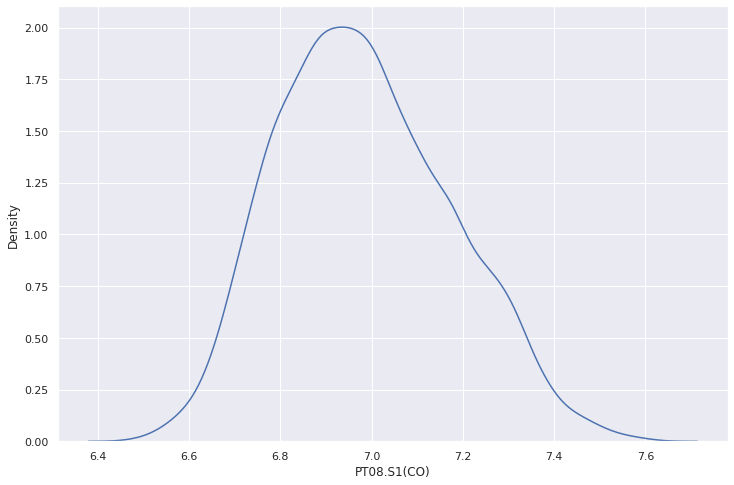

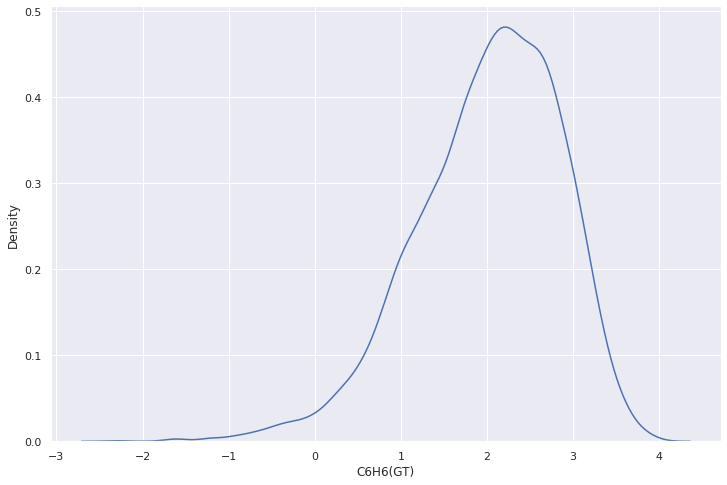

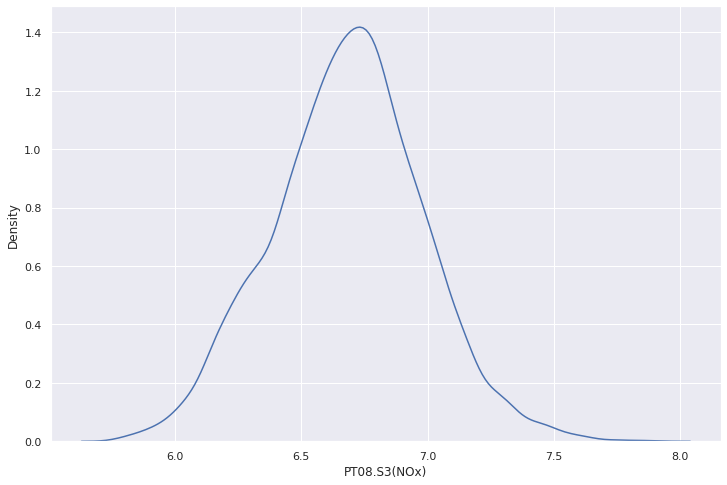

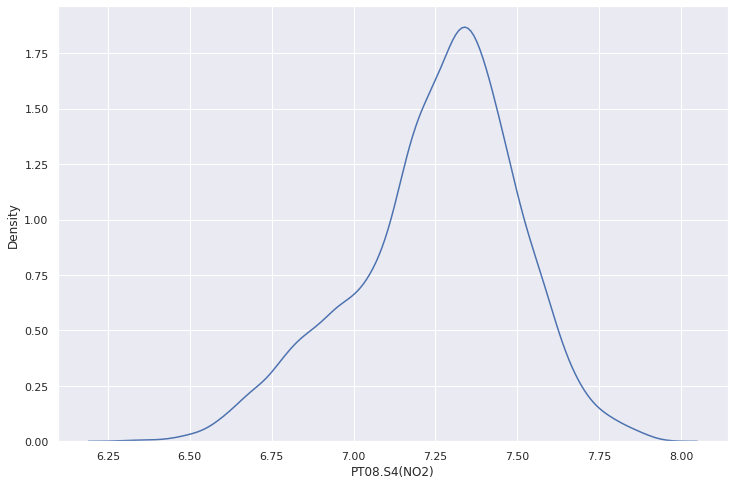

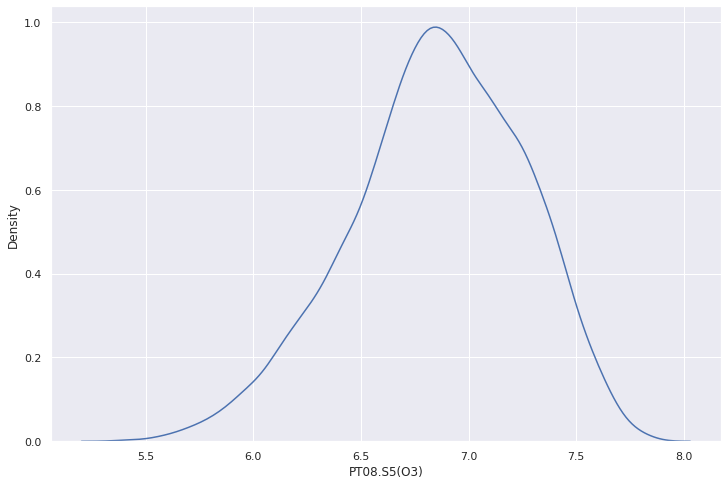

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


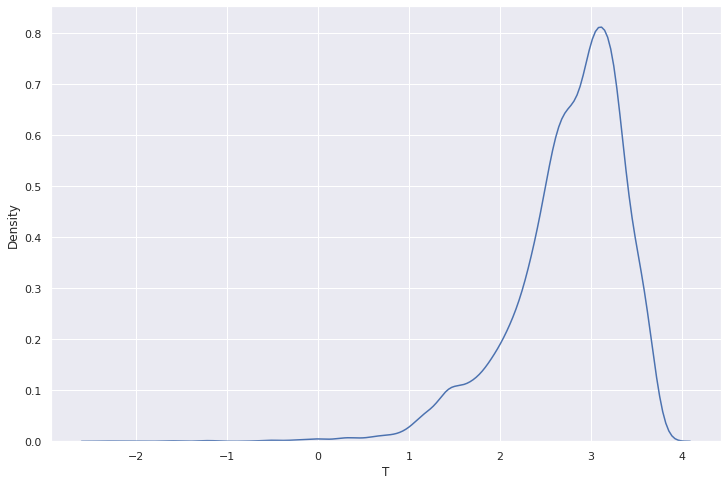

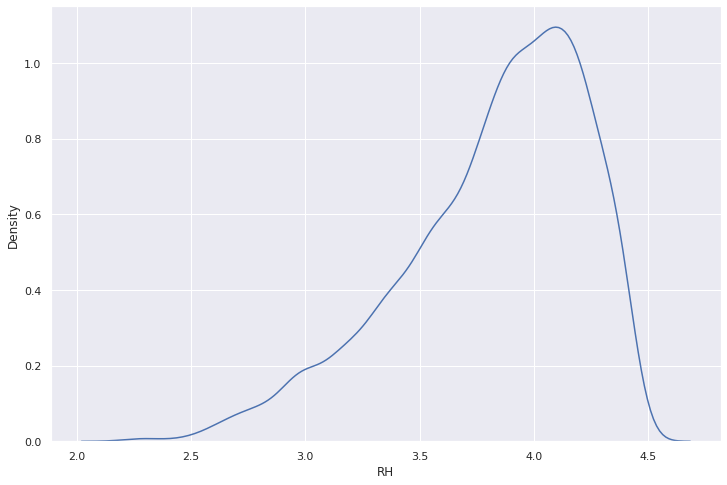

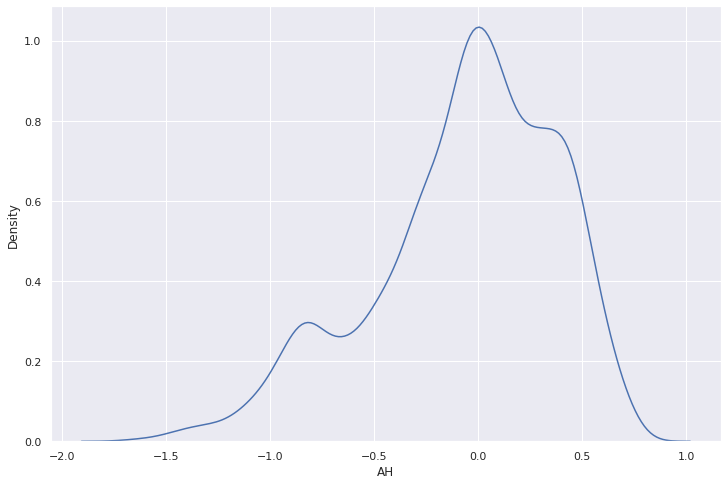

In [ ]:
for col in df.columns:
    sns.kdeplot(data=np.log(df[col]))
    plt.show();


Most of the plots show that transformation doen't really help to make features less skewed so i'll do transformation for 'PT08.S3(NOx)' variable and target value as it's got much less skewed.

In [ ]:
data = df.copy()
data['day'] = data['Date'].dt.dayofyear
data = data.drop(columns='Date')
data[['PT08.S3(NOx)']] = np.log(df[['PT08.S3(NOx)']])
data[['C6H6(GT)']] = np.log(df[['C6H6(GT)']])

In [ ]:
data


,PT08.S1(CO),C6H6(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1360.0,2.476538,6.962243,1692.0,1268.0,13.6,48.9,0.7578
1,1292.0,2.240710,7.068172,1559.0,972.0,13.3,47.7,0.7255
2,1402.0,2.197225,7.038784,1555.0,1074.0,11.9,54.0,0.7502
3,1376.0,2.219203,6.995766,1584.0,1203.0,11.0,60.0,0.7867
4,1272.0,1.871802,7.094235,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...
9352,1314.0,2.602690,6.289716,1374.0,1729.0,21.9,29.3,0.7568
9353,1163.0,2.433613,6.403574,1264.0,1269.0,24.3,23.7,0.7119
9354,1142.0,2.517696,6.401917,1241.0,1092.0,26.9,18.3,0.6406
9355,1003.0,2.251292,6.553933,1041.0,770.0,28.3,13.5,0.5139


### Normalization/scaling

As there is element of time Series in a data, i'll train models on older data and test on chronologically newer. As data is already sorted by date i can just apply standart train_test_split without shuffle.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('C6H6(GT)', axis=1), data['C6H6(GT)'], random_state=1, shuffle=False)

scaler function allows to quickly scale dataset after train-test split.

In [ ]:
def scaler(scaler, X_train, X_test):
  X_train = pd.DataFrame(scaler().fit_transform(X_train), columns=X_train.columns)
  X_test = pd.DataFrame(scaler().fit_transform(X_test), columns=X_test.columns)
  return X_train, X_test

In [ ]:
X_train, X_test = scaler(MinMaxScaler, X_train, X_test)

## 3. ML model

From previous hw I see that the best result was achieved but performing sqrt transformation on th target. I'm going to use this transformation and the best hyperperparameters

In [ ]:
def evaluate_model(model, train, test, y_tr, y_tst):
    pred_train = model.predict(train) ** 2
    pred_test = model.predict(test) ** 2
    y_tr = y_tr ** 2
    y_tst = y_tst ** 2
    return pd.DataFrame({
        'train_RMSE': [mean_squared_error(y_tr, pred_train, squared=False)],
        'train_R2': [r2_score(y_tr, pred_train)],
        'test_RMSE': [mean_squared_error(y_tst, pred_test, squared=False)],
        'test_R2': [r2_score(y_tst, pred_test)]
    })


In [ ]:
linear_sqrt = LinearRegression(n_jobs=-1).fit(X_train, y_train)
res = evaluate_model(linear_sqrt, X_train, X_test, y_train, y_test)
res

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.963828,0.902767,1.861568,0.593617


As a pinnacle of ML methods I'll use gradient boost algorithm - catboostRegressor.

In [ ]:
cat_reg = CatBoostRegressor(random_state=SEED, verbose=False)
cat = cat_reg.fit(X_train, y_train)

In [ ]:
evaluate_model(cat, X_train, X_test, y_train, y_test)

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.2046,0.995618,0.836775,0.91789


Gradient boost doesn't seem to be all that good as it severely overfits. All in all, vanilla linear regression has test rmse of 0.77 and untuned cat_regressor test_rmse=0.93. I think hyperparameters tuning might have helped a lot but I'm not gonna perform it as it is not a goal of this hw.

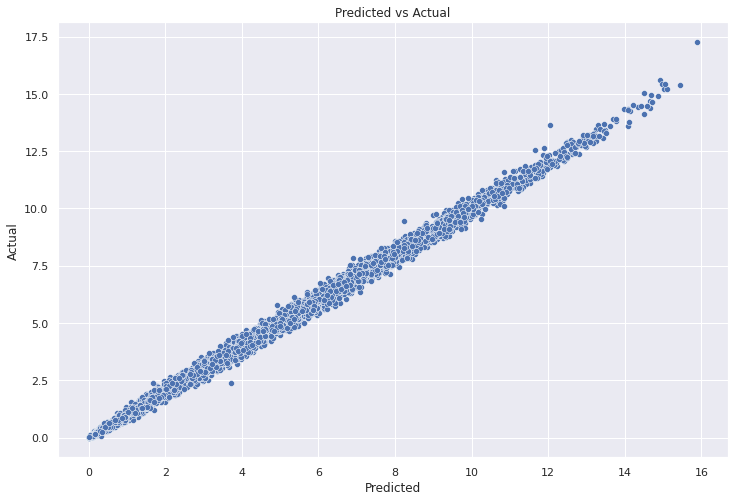

In [ ]:
sns.scatterplot(x=cat.predict(X_train) ** 2, y=y_train ** 2).set(title='Predicted vs Actual', xlabel='Predicted', ylabel='Actual');

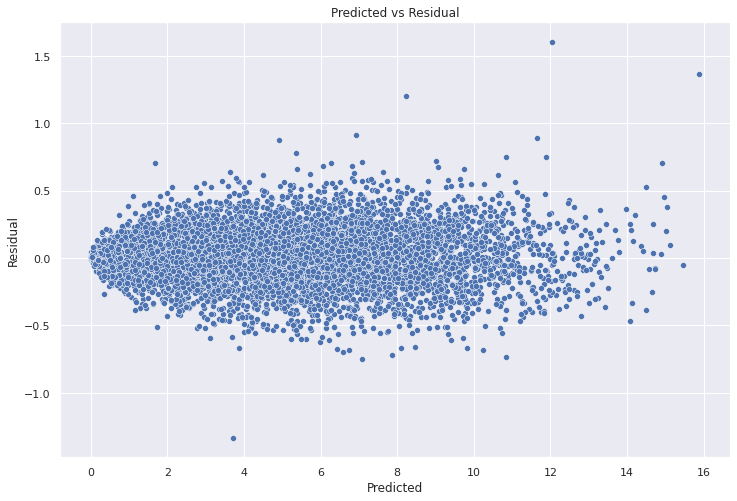

In [ ]:
sns.scatterplot(x=cat.predict(X_train) ** 2,
                y=y_train ** 2 - cat.predict(X_train) ** 2).set(title='Predicted vs Residual', xlabel='Predicted', ylabel='Residual');

The errors seem to have more dispertion in middle values, while they are relatively small by the ends.

## 4. Deep Learning solution

### Preprocessing and functions initialization

For deep learning solution I'm not going to use non-linear transformations as I expect the model to get it by itself.

In [ ]:
data = df.copy()

In [ ]:
data['day'] = data['Date'].dt.dayofyear
data = data.drop(['Date'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['C6H6(GT)'], axis=1), data['C6H6(GT)'], random_state=SEED, shuffle=True)

In [ ]:
X_train

,Time,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,day
108,06.00.00,1.4,1157.0,51.0,830.0,138.0,1030.0,80.0,1584.0,1083.0,11.4,70.5,0.9475,75
493,07.00.00,3.1,1636.0,342.0,1168.0,207.0,721.0,110.0,1926.0,1438.0,13.8,58.2,0.9129,91
824,02.00.00,0.7,900.0,66.0,635.0,47.0,1207.0,60.0,1307.0,836.0,11.1,63.2,0.8331,105
1111,01.00.00,0.7,838.0,45.0,601.0,33.0,1361.0,43.0,1220.0,434.0,14.2,45.5,0.7333,117
889,19.00.00,6.4,1689.0,783.0,1474.0,323.0,560.0,149.0,2298.0,1492.0,13.9,78.0,1.2303,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,16.00.00,1.9,1085.0,209.0,1004.0,106.0,888.0,95.0,1454.0,816.0,21.0,25.4,0.6264,99
491,05.00.00,0.6,909.0,31.0,545.0,44.0,1473.0,58.0,1131.0,436.0,14.6,36.0,0.5947,91
488,02.00.00,0.9,972.0,66.0,639.0,47.0,1222.0,70.0,1256.0,678.0,14.8,40.8,0.6834,91
1216,10.00.00,2.7,1315.0,212.0,1072.0,191.0,736.0,116.0,1833.0,1273.0,16.3,73.2,1.3458,121


In [ ]:
encoder = CyclicalFeatures(variables=['Time'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
#X_train, X_test = transformer(X_train, X_test)

As my loss function I'll use MSE.

In [ ]:
loss_fn = nn.MSELoss()
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

For validationg results while choosing the best epoch of my model I'm going to split test set on validation and test.

In [ ]:
X_val = X_test[:len(X_test)//2, :]
X_test = X_test[len(X_test)//2:, :]
y_val = y_test[:len(y_test)//2]
y_test = y_test[len(y_test)//2:]

In [ ]:
class RegPartDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, X, y):
        # Save target and predictors
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


In [ ]:
train_ds = RegPartDataset(X_train, y_train)
# val = RegPartDataset(X_val, y_val)
# test = RegPartDataset(X_test, y_test)

The fuction that trains networks consists of training network on given number of epochs with given batch size, with or witouht early stop. After each epoch I save validation score to choose the best state of model after training.

For early stop I've written 2 critereas. Fist one is finding a plato. It means that validation loss nearly don't change for 2 epochs. Second one is when the model doesn't find new local minimum at last 10 epochs. This second one might be weird but the reason of it is that the errors don't monotonicly decrease but rather randomly get less whith random differeces.

In [ ]:
def train(model, n_epochs=50, batch_size=64, disable_bar=False, early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val = []
  history_tr = []
  train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()
      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")
      for X_batch, y_batch in loop :
          # take a batch
          # X_batch = X_train[start:start+batch_size]
          # y_batch = y_train[start:start+batch_size]
          # forward pass
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          model.get_optimizer().zero_grad()
          loss.backward()
          # update weights
          model.get_optimizer().step()
          # print progress
          loop.set_postfix(mse=loss.item())
      # evaluate accuracy at end of each epoch
      # evaluate accuracy at end of each epoch
      model.eval()
      y_pred = model(X_val)
      y_pred_tr = model(X_train)
      loss_val = loss_fn(y_pred, y_val).item()
      history_val.append(loss_val)
      loss_tr = loss_fn(y_pred_tr, y_train).item()
      history_tr.append(loss_tr)
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if early_stop:
        if epoch > 3 and abs(history_val[-3] - history_val[-2]) < 0.01 and abs(history_val[-3] - history_val[-1]) < 0.01:
          print('')
          print('Early stop: plato found')
          break
        if epoch > 20 and (np.min(history_val[-6: -3]) - np.min(history_val[-3:])) < 0:
          print('')
          print('Early stop: error increasing')
          break
  return history_tr, history_val, best_weights

In [ ]:
def show_results(history_tr, history_tst, metric='RMSE'):
  print(f'Best val {metric} = {min(np.sqrt(history_tst))}')
  plt.plot(np.sqrt(history_tst))
  plt.plot(np.sqrt(history_tr))
  plt.legend(labels=[f'Val {metric}', f'Train {metric}'])
  plt.title(f'{metric} (original scale) on epochs')
  plt.show()

In [ ]:
def evaluate_network(model, train, test, y_tr, y_tst):
    pred_train = model(train).detach().numpy()
    pred_test = model(test).detach().numpy()
    y_tr = y_tr.detach().numpy()
    y_tst = y_tst.detach().numpy()
    return pd.DataFrame({
        'train_RMSE': [mean_squared_error(y_tr, pred_train, squared=False)],
        'train_R2': [r2_score(y_tr, pred_train)],
        'test_RMSE': [mean_squared_error(y_tst, pred_test, squared=False)],
        'test_R2': [r2_score(y_tst, pred_test)]
    })

### Basic network

Firstly, I'll try primitive model with 2 hidden layers and neither normalization nor reguralization.

In [ ]:
class RegressionNetwork(nn.Module):
  def __init__(self, input_len, learning_rate=0.001):
    super(RegressionNetwork, self).__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = F.relu(self.fc3(x))
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer



In [ ]:
basic_network = RegressionNetwork(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train(basic_network, 100, 32)

Epoch 28: 100%|██████████| 211/211 [00:01<00:00, 159.20batch/s, mse=13.7]



Early stop: error increasing


Best val RMSE = 3.5444237393206617


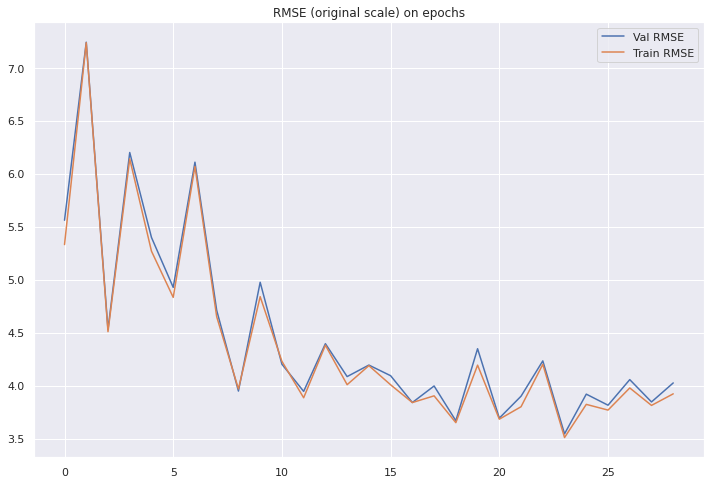

In [ ]:
basic_network.load_state_dict(best_weights)
show_results(history_tr, history_tst)

In [ ]:
evaluate_network(basic_network,
                 X_train,
                 X_test,
                 y_train,
                 y_test)

,train_RMSE,train_R2,test_RMSE,test_R2
0,3.509446,0.77969,3.490059,0.776459


The results are rather underwhelming as they are much worse than the ML ones and the plot shows that the errors are pretty random throughout the training process.  I'll try to make the model more complicated by adding additional layers and batch normalization.

### More advanced network

In [ ]:
class RegressionNetworkNorm(nn.Module):
  def __init__(self, input_len, learning_rate=0.001, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 32)
    self.fc2 = nn.Linear(32, 64)
    self.m2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 16)
    self.m3 = nn.BatchNorm1d(16)
    self.fc4 = nn.Linear(16, 1)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     #x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = self.fc4(x)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

Through some number of experiments I found out that normalization is improving results only after 2 layer.

In [ ]:
norm_network = RegressionNetworkNorm(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train(norm_network, 50, 32)

Epoch 21: 100%|██████████| 211/211 [00:01<00:00, 166.04batch/s, mse=1.98]



Early stop: error increasing


Best val RMSE = 1.6700625711699921


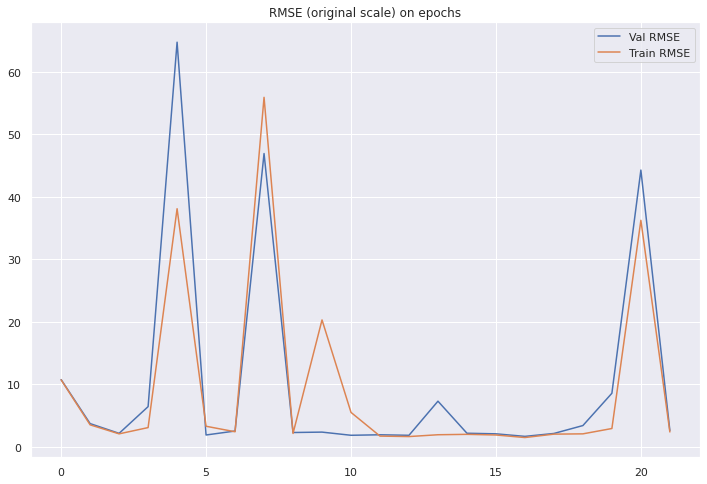

In [ ]:
norm_network.load_state_dict(best_weights)
show_results(history_tr, history_tst)

In [ ]:
evaluate_network(norm_network,
                 X_train,
                 X_test,
                 y_train,
                 y_test)

,train_RMSE,train_R2,test_RMSE,test_R2
0,1.483787,0.960618,1.374609,0.965322


The results got much better - the rmse is less than linear regression but the plot looks weird - it has a lot of peaks, although the majority of epoch have little rmse. I'll try another batch size


Early stop: error increasing
Model with batch size = 26
Best val RMSE = 1.7728847364814433


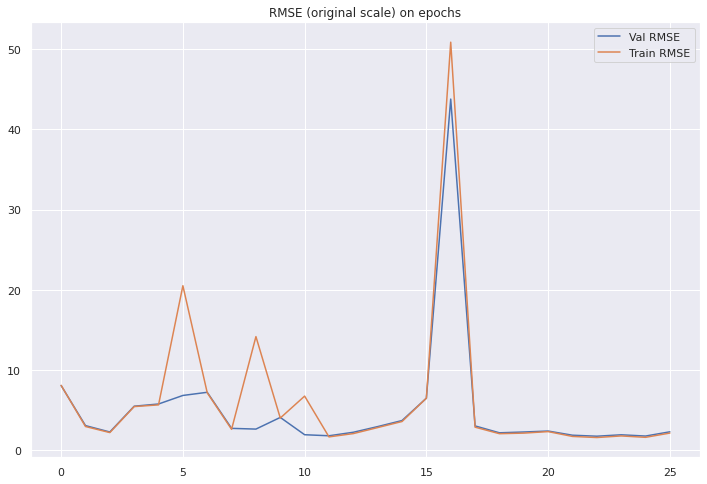


Early stop: error increasing
Model with batch size = 32
Best val RMSE = 1.7280577662048988


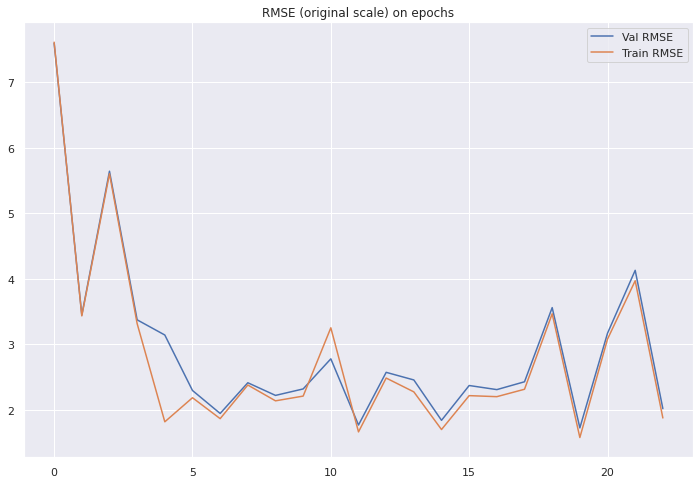


Early stop: error increasing
Model with batch size = 36
Best val RMSE = 1.8132713255144308


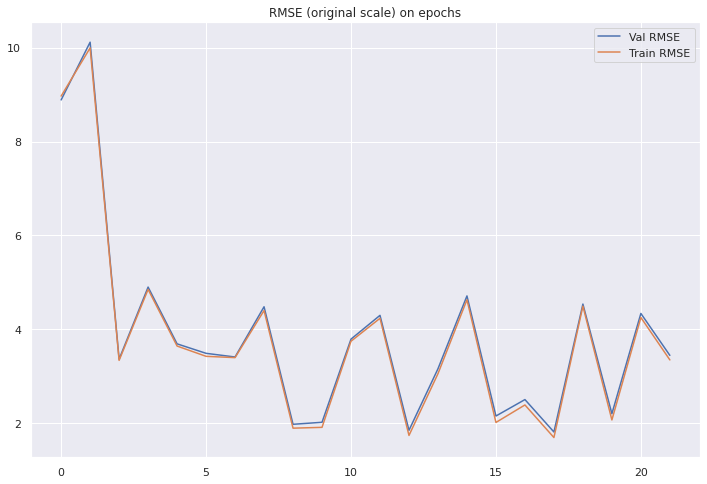


Early stop: error increasing
Model with batch size = 40
Best val RMSE = 1.7892300056767747


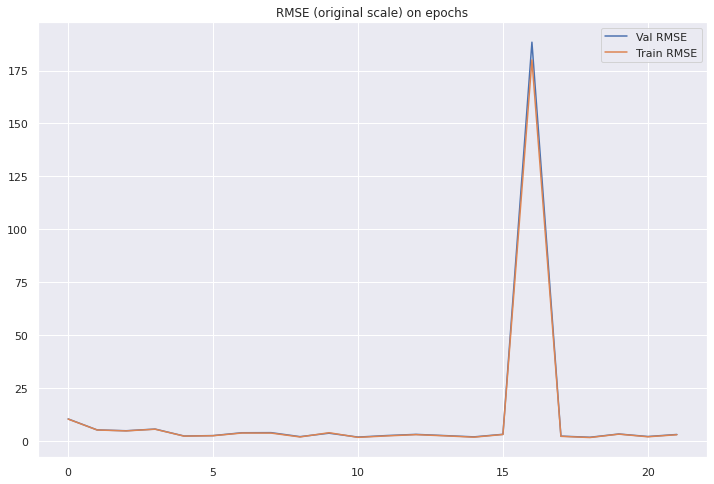


Early stop: error increasing
Model with batch size = 44
Best val RMSE = 1.848947344107051


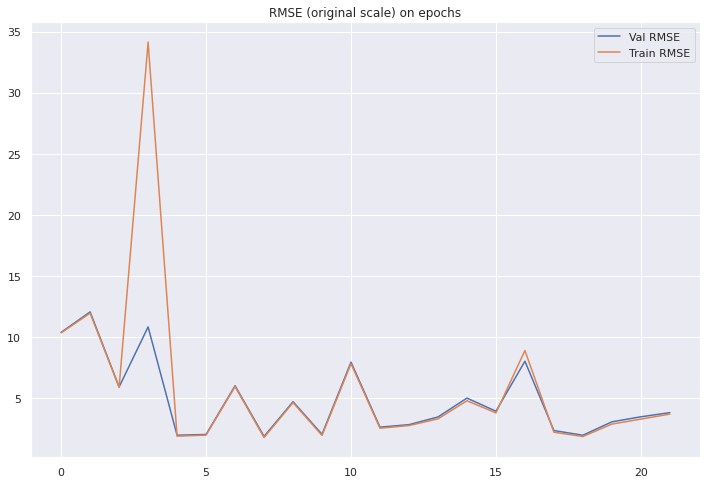

In [ ]:
results = pd.DataFrame(columns=['train_RMSE', 'train_R2', 'test_RMSE', 'test_R2'])
for batch_size in (26, 32, 36, 40, 44):
  network = RegressionNetworkNorm(X_train.size()[-1])
  history_tr, history_tst, best_weights = train(network, 50, batch_size, disable_bar=True)
  network.load_state_dict(best_weights)
  print(f'Model with batch size = {batch_size}')
  show_results(history_tr, history_tst)
  res = evaluate_network(network,
                 X_train,
                 X_test,
                 y_train,
                 y_test)
  results = pd.concat([results, res], axis=0)

In [ ]:
results.index = (26, 32, 36, 40, 44)

In [ ]:
results

,train_RMSE,train_R2,test_RMSE,test_R2
26,1.608000,0.953748,1.500107,0.958701
32,1.580745,0.955303,1.454796,0.961159
36,1.695107,0.948601,1.570308,0.954746
40,1.665850,0.950360,1.544149,0.956241
44,1.758444,0.944689,1.667436,0.948974


The optimal batch size seems to be 32. I'll try to tune hyperparamters to get better result.

### Hyperparameters tuning

For tuning I'll create a new calss where all number s of layers will be hyperparametrers. I'll also tune learning rate and weight decay - l2 regularization of adam to probably decrease possible overfitting.

In [ ]:
class RegressionNetworkHyper(nn.Module):
  def __init__(self, input_len=11, n1=32, n2=64, n3=16, learning_rate=0.01, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n1)
    self.fc2 = nn.Linear(n1, n2)
    self.m2 = nn.BatchNorm1d(n2)
    self.fc3 = nn.Linear(n2, n3)
    self.m3 = nn.BatchNorm1d(n3)
    self.fc4 = nn.Linear(n3, 1)

    self.weight_decay = weight_decay
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     #x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = self.fc4(x)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

For finding hyperparams I'll use optuna.

For calculating score I'll train model 3 times and calculaye average. The reasoing behid is that seed doesn't work and I get different results every time I train a model so calculating average score is a way to decrease randomness.

In [ ]:
def objective(trial):
    params_model = {'n1': trial.suggest_int('n1', 8, 164, 8),
                    'n2': trial.suggest_int('n2', 8, 128, 8),
                    'n3': trial.suggest_int('n3', 8, 128, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01, log=True),
                    'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1, log=True)
    }
    reg = RegressionNetworkHyper(X_train.size()[-1], **params_model)
    _, _, best_weights = train(reg, 50, 32, disable_bar=True)
    reg.load_state_dict(best_weights)
    score = np.sqrt(loss_fn(reg(X_val), y_val).item())

    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-03-26 10:51:43,669] A new study created in memory with name: no-name-eab132e5-3582-4a2e-97e8-8cb8552af9e6
/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [8, 164] and step=8, but the range is not divisible by `step`. It will be replaced by [8, 160].
  warnings.warn(



Early stop: error increasing
[I 2023-03-26 10:51:53,540] Trial 0 finished with value: 1.769179555540831 and parameters: {'n1': 120, 'n2': 112, 'n3': 56, 'learning_rate': 0.00035633401541093705, 'weight_decay': 0.00019169468171534006}. Best is trial 0 with value: 1.769179555540831.

Early stop: error increasing
[I 2023-03-26 10:52:01,966] Trial 1 finished with value: 1.8884255723010006 and parameters: {'n1': 56, 'n2': 72, 'n3': 56, 'learning_rate': 0.00024686678072239753, 'weight_decay': 0.0663007354137389}. Best is trial 0 with value: 1.769179555540831.

Early stop: error increasing
[I 2023-03-26 10:52:10,229] Trial 2 finished with value: 1.7310316147762814 and parameters: {'n1': 120, 'n2': 24, 'n3': 128, 'learning_rate': 0.0011168431307875825, 'weight_decay': 1.6730445019861475e-08}. Best is trial 2 with value: 1.7310316147762814.

Early stop: error increasing
[I 2023-03-26 10:52:19,438] Trial 3 finished with value: 1.8117512438888144 and parameters: {'n1': 96, 'n2': 112, 'n3': 16, '

In [ ]:
print('Best Validation RMSE: {}'.format(study.best_value))
print('Best Params: {}'.format(study.best_params))

Best Validation RMSE: 1.6084270463169832
Best Params: {'n1': 96, 'n2': 88, 'n3': 72, 'learning_rate': 0.002585028301465163, 'weight_decay': 1.6647431687442186e-06}


In [ ]:
reg = RegressionNetworkHyper(X_train.size()[-1], **study.best_params)
history_tr, history_val, best_weights = train(reg, 50, 32, disable_bar=False, early_stop=False)
reg.load_state_dict(best_weights)

Epoch 49: 100%|██████████| 211/211 [00:01<00:00, 132.64batch/s, mse=1.9]


<All keys matched successfully>

Best val RMSE = 1.6470723216721856


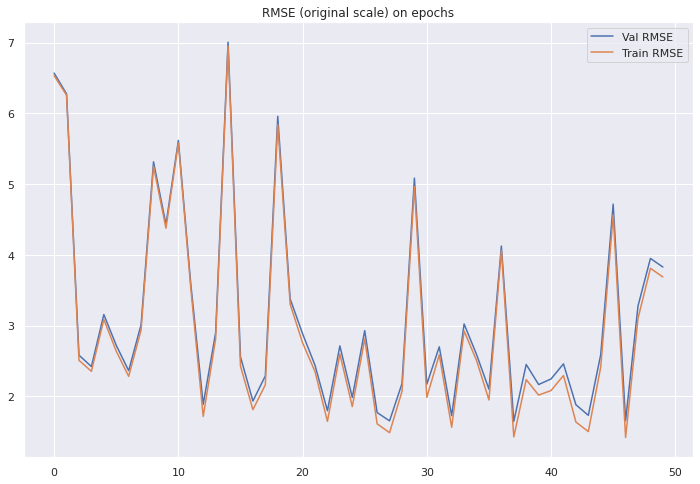

In [ ]:
show_results(history_tr, history_val)

In [ ]:
evaluate_network(reg,
                 X_train,
                 X_test,
                 y_train,
                 y_test)

,train_RMSE,train_R2,test_RMSE,test_R2
0,1.427693,0.963539,1.31277,0.968372


The results of tuned model are even better - the test rmse now is 1.31. The plot in the other hand looks weird but anyway the result has improved.

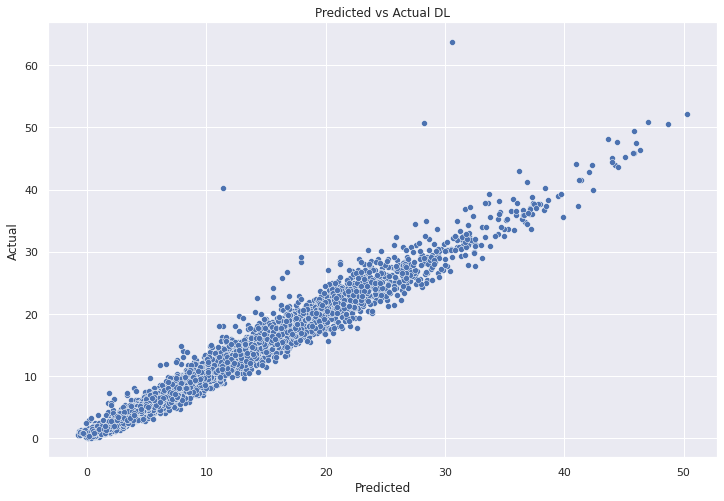

In [ ]:
sns.scatterplot(x=reg(X_train).squeeze().detach().numpy(),
                y=y_train.squeeze().detach().numpy()).set(
                    title='Predicted vs Actual DL', xlabel='Predicted', ylabel='Actual');

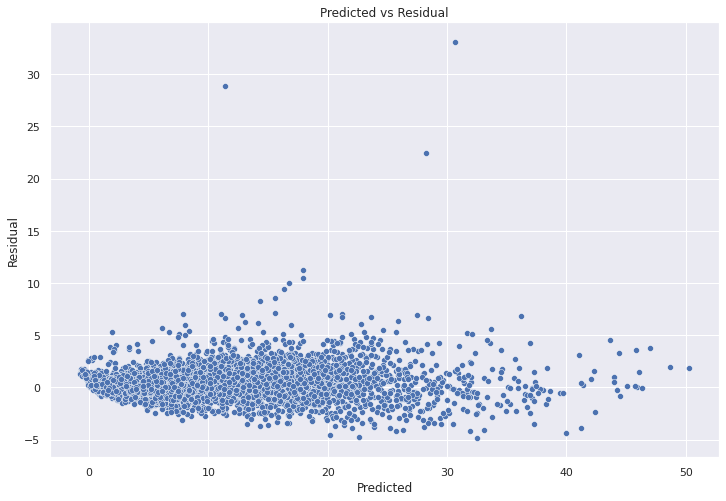

In [ ]:
sns.scatterplot(x=reg(X_train).squeeze().detach().numpy(),
                y=y_train.squeeze().detach().numpy() - reg(X_train).squeeze().detach().numpy()).set(title='Predicted vs Residual', xlabel='Predicted', ylabel='Residual');

The errors seem to be simmetricaly distributed. And homoscedasticity was achieved.

All in all, neural networks achived pretty good results - better than linear regression but worse then gradient boosting. Neural networks are significantly harder to create and tune, they study more. Another big issue is reproducability - I achieved significantly different results when I ran the same code (although I tried to fix seed in the beginning).

## 5. Conclusions

I've preformed 3 types of task using deep learning methods: regression, classification and computer vision. On tablar data tasks the achieved results were better then common linear or logistic regression but in both cases were worse that gradient boosting. In case of CV, achieved results appeared relatively good, although significantly worse than in case of using pretrained models. Those, combined with trained by myself final layer gave the best results. I think that the main limitation in this part was the dataset - I  coudn't achieve stable results and so my models tended to overfit. Perhaps with bigger dataset resulting accuracy woud have been higher.